In [1]:
import os
import shutil
import yaml

import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import argparse
import re

from src.utils.helpers import makedir
from src.models import seg_model
from src.training import push
from src.training import prune
from src.training import train_and_test as tnt

from src.utils import save
from src.utils.log import create_logger
import logging
from src.data.raman_dataset import create_raman_mask_dataloaders_from_ids

import matplotlib.pyplot as plt

# Upsampling Masks Test

A key assumption in the ProtoPNet segmentation approach is that we are able to reconstruct a good segmentation mask from a low spatial resolution probability map. Let's explore the best case to see if this is even possible in ideal conditions.

In [2]:
# config for training
config_file = "./configs/unet_segment_newdata.yaml"
with open(config_file, "r") as stream:
    conf = yaml.safe_load(stream)

In [3]:
raman_id = ['E919-24_sample1_1']
val_dl = create_raman_mask_dataloaders_from_ids(
    raman_id,
    conf,
    shuffle=False,
    in_memory=True,
    is_train=False,
)

In [12]:
feature_map_size = (16, 16)

Original shape: torch.Size([1, 512, 512])


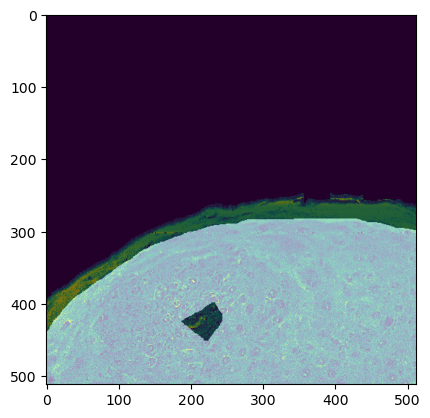

Upsampled shape: torch.Size([1, 1, 512, 512])


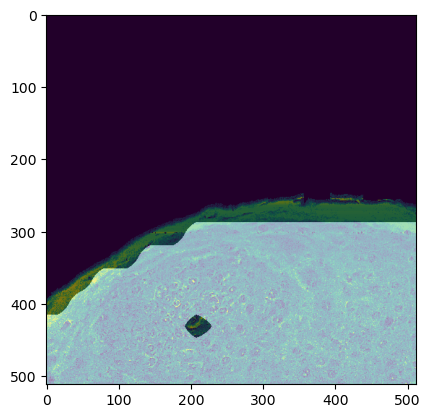

In [13]:
for x, y in val_dl:
    batch_i = 0
    if y[batch_i].sum() < 50:
        continue
    downsampled = torch.nn.functional.interpolate(
        y[batch_i].unsqueeze(0),
        size=feature_map_size,
        mode="bilinear",
        align_corners=False,
    )
    upsampled = torch.nn.functional.interpolate(
        downsampled,
        size=(y[batch_i].shape[1], y[batch_i].shape[2]),
        mode="bilinear",
        align_corners=False,
    )
    upsampled_bin = (upsampled >= 0.5).long()

    print("Original shape:", y[batch_i].shape)
    plt.imshow(x[batch_i, 7].squeeze().cpu().numpy())
    plt.imshow(y[batch_i].squeeze().cpu().numpy(), cmap='gray', alpha=0.5)
    plt.show()
    print("Upsampled shape:", upsampled_bin.shape)
    plt.imshow(x[batch_i, 7].squeeze().cpu().numpy())
    plt.imshow(upsampled_bin.squeeze().cpu().numpy(), cmap='gray', alpha=0.5)
    plt.show()
    break

In [16]:
def compute_average_dice(val_dl, feature_map_size):
    dice_total = 0
    for x, y in val_dl:
        downsampled = torch.nn.functional.interpolate(
            y,
            size=feature_map_size,
            mode="bilinear",
            align_corners=False,
        )
        upsampled = torch.nn.functional.interpolate(
            downsampled,
            size=(y.shape[2], y.shape[3]),
            mode="bilinear",
            align_corners=False,
        )

        # compute dice score between y and upsampled
        y_true = y.cpu().numpy().flatten()
        y_pred_bin = (upsampled >= 0.5).cpu().numpy().flatten()
        intersection = (y_true * y_pred_bin).sum()
        dice_score = (2. * intersection) / (y_true.sum() + y_pred_bin.sum())
        dice_total += dice_score
    return dice_total / len(val_dl)

sizes = [(512, 512), (32, 32), (16, 16), (8, 8), (4, 4)]
for size in sizes:
    avg_dice = compute_average_dice(val_dl, size)
    print(f"Average Dice score for size {size}: {avg_dice:.4f}")

Average Dice score for size (512, 512): 1.0000
Average Dice score for size (32, 32): 0.9804
Average Dice score for size (16, 16): 0.9581
Average Dice score for size (8, 8): 0.9113
Average Dice score for size (4, 4): 0.8356
